# Formatting your data: feature extraction from motion tracking output

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucasmiranda42/deepof/blob/master/docs/source/tutorial_notebooks/deepof_preprocessing_tutorial.ipynb)

##### What we'll cover:
    
* Create and run a project.
* Load a previously generated project.
* Interact with your project: generate coordinates, distances, angles, and areas.
* Exploratory visualizations: heatmaps and processed animations.

In [1]:
# # If using Google colab, uncomment and run this cell and the one below to set up the environment
# # Note: because of how colab handles the installation of local packages, this cell will kill your runtime.
# # This is not an error! Just continue with the cells below.
# import os
# !git clone -q https://github.com/mlfpm/deepof.git
# !pip install -q -e deepof --progress-bar off
# os.chdir("deepof")
# !curl --output tutorial_files.zip https://datashare.mpcdf.mpg.de/s/Hu1XjZkY9zml0mm/download
# !unzip tutorial_files.zip

In [2]:
# import os
# os.chdir("deepof")
# import os, warnings
# warnings.filterwarnings('ignore')

Let's start by importing some packages. We'll use python's os library to handle paths, pickle to load saved objects, pandas to load data frames, and the data entry API within DeepOF, located in deepof.data

In [3]:
import os
import pandas as pd
import pickle
import deepof.data

We'll also need some plotting gear:

In [4]:
import deepof.visuals
import matplotlib.pyplot as plt
import seaborn as sns

### Creating and running a project

With that out of the way, the first thing to do when starting a DeepOF project is to load your videos and DeepLabCut tracking files into a deepof.data.Project object. 

Like depicted in the cell below, the three crucial parameters to input are the project, video and tab paths. 

* project_path specifies where the project folder containing all processing and output files will be created.
* video_path points towards where your DLC or SLEAP labelled videos are stored.
* similarly, table_path should point to the directory containing all tracking files (see section on supported input files below).
* last but not least, you can give your project a name (optional; _deepof_project_ by default).

The dataset used in this tutorial is a subset of the social interaction (SI) dataset used in DeepOF's original paper. It contains six 10-minute-long videos with two animals (a C57Bl6 and a CD1) tracked in a round arena, tracked with DeepLabCut. Three of the C57Bl6 mice have been exposed to chronic social defeat stress (CSDS).

In [5]:
my_deepof_project_raw = deepof.data.Project(
    project_path=os.path.join("tutorial_files"),
    video_path=os.path.join("tutorial_files/Videos/"),
    table_path=os.path.join("tutorial_files/Tables/"),
    project_name="deepof_tutorial_project",
    arena="circular-autodetect",
    animal_ids=["B", "W"],
    table_format="h5",
    video_format=".mp4",
    exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
    video_scale=380,
    iterative_imputation="partial",  # "full",
    smooth_alpha=1,
    exp_conditions=None,
    # number_of_rois=3, # another optional input argument that allows you to define up to 20 different regions of interest during project creation
)

As you may see, there are some extra (optional) parameters in the call above. These specify some details on how the videos and tracks will be processed. Some include:

* arena: some functions within DeepOF (as you will see in the next tutorial on supervised annotations) require the program to detect the arena. The following section explains how to handle this step in more detail.
* animal_ids: in case more than one animal is present in the dataset, the IDs assigned to each during tracking need to be specified as a list. For SLEAP projects, this will be detected automatically, but can be overriten.
* exclude_body_parts: while DeepOF originally relies on 14 body part tracking models, body parts along the tail are no longer used. This step could be bypassed using smaller models following an 11-body-part scheme, such as the one presented in the landing page of the documentation. Custom labelling schemes are also supported (see tutorials).
* video_scale: diameter of the arena (in mm) if circular. In the case of polygonal arenas, the length (in mm) of the first edge as specified in the GUI (see next section) should be provided.
* smooth_alpha: smoothing intensity. The higher the value, the more smoothing is applied.
* exp_conditions: dictionary with a video IDs as keys, and data frames with all experimental conditions as values. DeepOF will use this information to enable all sorts of comparisons between conditions, as we will see in the following tutorials. We'll leave it blank for now and update it afterwards.

For more details, feel free to visit the [full API reference](https://deepof.readthedocs.io/en/latest/#full-api-reference).

Let's then create our first project, by running the `.create()` method in our newly created object:

In [6]:
my_deepof_project = my_deepof_project_raw.create(force=True)

Setting up project directories...


Computing areas               : 100%|██████████| 6/6 [00:01<00:00,  3.39table/s]


Done!


**NOTE**: the `force` parameter allows DeepOF to override an existing project in the same directory. Use with caution!

**NOTE 2**: the cell above can take a significant amount of time to run in Google colab. Feel free to skip and continue with the loaded results below.

As you will see, this organizes all required file into a folder in the specified path. Moreover, some processing steps are computed on the go, such as distances, angles and areas. This makes it easier for DeepOF to load all required features later on, without the need to compute them every time.

### Arena detection

As mentioned above, one of the key aspects of project creation involves setting up the arena detection mechanism, which will be used in downstream tasks, such as climbing detection and overall video scaling.

You can contrAlong these lines, the package provides tools for detecting elliptical arenas specifically (as seen in this tutorial), and general polygonal shapes (such as squares, rectangles, Y-mazes, etc).

In principle, DeepOF can detect your arenas automatically by relying in [SAM (Segment Anything Model)](https://segment-anything.com/), a state-of-the-art image segmentation deep learning model. By selecting `arena='circular-autodetect'`, or `arena='polygonal-autodetect'`, users can benefit from this approach. A folder named `Arena_detection` will be created in your project directory, which contains samples of the detected arenas for all videos, so you can visually inspect if DeepOF did a good job.



Moreover, manual annotation can be selected using `arena='circular-manual'`, and `arena='polygonal-manual'`. In this case, you will see a window per video appear, allowing you to manually mark where the arena is with just a few clicks. All results will be stored for further processing.

Here, clicking anywhere in the video will make an orange marker appear. In the case of polygonal arenas, at least a marker per corner should be used. When dealing with circular (or elliptical) arenas, DeepOF will fit an ellipse to the marked points after a minimum of 5 clicks. The ellipse can always be refined by adding more markers. Once finished with a video, press `q` to save and move to the next one. If you made a mistake and would like to correct it, press `d` to delete the last added marker. Moreover, after you tagged at least one video, you'll see the `p` option appear, which will copy the last marked arena to all remaining videos in the dataset.

**NOTE**: If you select `arena='polygonal-autodetect'`, you will still be prompted with the GUI to select the arena just once, so SAM roughly knows how the segmentation it should return looks like. Detection in all remaining videos will be automatic. This is not the case for `arena='circular-autodetect'`, as we already know we're looking for a circle.

![arena_GUI](./Assets/arena_GUI.png)

One last thing is that, in polygonal arenas, the first edge you input will be used to scale the coordinates to the proper distances (pixels to millimeters). Make sure you always mark the same edge first, and that it coincides with the length passed to the "video_scale" parameter when creating the project. In saved images of automatically detected polygons, you'll see orange circles marking two arena corners. These should match the first edge you selected when prompting SAM, ensuring data is properly scaled.

If after all this work you make a mistake while labelling, or see that automatic detection failed in some cases, don't worry! You can always edit manually annotated arenas (or rerun automatic annotation) for specific videos using the `.edit_arenas()` method. Just pass a list with the IDs of the videos you would like to relabel, and the GUI will pop up once again. The same methods described above can be passed to the `arena_type` parameter.

**NOTE**: If you don't pass any video IDs, all videos will be selected by default.

In [7]:
my_deepof_project.edit_arenas(
    video_keys=['20191204_Day2_SI_JB08_Test_54', '20191204_Day2_SI_JB08_Test_62'],
    arena_type="circular-autodetect",
)

Editing 2 arenas


Detecting arenas              : 100%|██████████| 2/2 [00:38<00:00, 19.14s/arena]

Done!


### Supported input tracking files:

DeepOF currently supports input from both [DeepLabCut](url_here) and [SLEAP](url_here). While DeepOF will try to detect automatically which file type you're trying to use, this can be forced with the `table_format` parameter in the `deepof.data.Project()` call depicted in the previous section.

For DeepLabCut, we support:

* Single and multi-animal project CSV files (indicated simply with `table_format='csv'`.
* Single and multi-animal project h5 files (indicated simply with `table_format='h5'`.

For SLEAP, you can use:

* SLP files (indicated as with `table_format='slp'`.
* Raw .npy files (indicated with `table_format='npy'`.
* h5 files (indicated with `table_format=analysis.h5`.

Downstream processing should be identical regardless of the files selected, as DeepOF internally brings all these inputs into an equivalent representation. Let's continue!

### Loading a previously generated project

Once you ran your project at least once, it can be loaded without much effort from the path you specified in the first place (plus the project name -_deepof_project_, if you didn't specify otherwise-).

In [8]:
# Load a previously saved project
my_deepof_project = deepof.data.load_project("./tutorial_files/deepof_tutorial_project/")

### Extend a previously generated project

If you'd like to add data (videos and tracks) to a previously processed project, you can use the `extend` method instead of `create`. Just pass the path to your previously processed project, and DeepOF will take care of merging the two. A new directory will be created with all files corresponding to the merged projects.

**NOTE**: Your old files will not be deleted.

In [9]:
# Extend a previously saved project
my_deepof_project=my_deepof_project_raw.extend(
    "./tutorial_files/deepof_tutorial_project/",) 

Loading previous project...
Processing data from 0 experiments...


### Interacting with your project: generating coordinates, distances, angles, and areas.

That's it for basic project creation. We now have a DeepOF project up and running! Before ending the tutorial, however, let's explore the object that the commands above produced.

For starters, if we print it, we see it's a DeepOF analysis of 6 videos. Furthermore, the object belongs to a custom class within DeepOF, called Coordinates. This class allows the package to store all sorts of relevant information required for further processing, as we'll see below:

In [10]:
print(my_deepof_project)
print(type(my_deepof_project))

deepof analysis of 6 videos
<class 'deepof.data.Coordinates'>


As described before, the `.create()` method runs most of the heavy preprocessing already, which allows us to extract features including coordinates, distances, angles, and areas. Let's see how that works!

![preprocessing](./Assets/deepof_preprocessing.png)

With the `.get_coords()` method, for example, we can obtain the processed (smooth and imputed) tracks for all videos in a dictionary. The returned objects are called table dictionaries (TableDict is the name of the class). They follow a dictionary-like structure, where each value is a data frame. They also provide a plethora of extra methods, some of which we'll cover in these tutorials. Let's retrieve these for one of the animals:

In [11]:
my_deepof_project.get_coords(polar=False, center="Center", align="Spine_1")['20191204_Day2_SI_JB08_Test_54']

B_Spine_1            B_Center      B_Left_bhip             \
                           x          y        x    y           x          y   
00:00:00                 0.0  13.325157      0.0  0.0    9.299380 -10.043816   
00:00:00.040002666       0.0  13.325157      0.0  0.0    9.299380 -10.043816   
00:00:00.080005333       0.0  13.325157      0.0  0.0    9.299380 -10.043816   
00:00:00.120008          0.0  12.329721      0.0  0.0    8.271627 -11.473263   
00:00:00.160010667       0.0  12.184032      0.0  0.0    8.779927 -12.331782   
...                      ...        ...      ...  ...         ...        ...   
00:09:59.799986665       0.0  14.084511      0.0  0.0   12.934637  -9.662336   
00:09:59.839989332       0.0  12.209805      0.0  0.0   12.787276 -10.919778   
00:09:59.879991999       0.0  15.747278      0.0  0.0   10.409651  -9.370635   
00:09:59.919994666       0.0  15.747278      0.0  0.0   10.409651  -9.370635   
00:09:59.959997333       0.0  15.747278      0.0  0.0   10.409651  -9.370635   

                   B_Left_ear            B_Left_fhip             ...  \
                            x          y           x          y  ...   
00:00:00             0.078639  28.362360   11.113320  11.260839  ...   
00:00:00.040002666   0.078639  28.362360   11.113320  11.260839  ...   
00:00:00.080005333   0.078639  28.362360   11.113320  11.260839  ...   
00:00:00.120008     -0.290829  28.613625   12.340172   9.265053  ...   
00:00:00.160010667   0.698089  27.811297   12.141177   8.484510  ...   
...                       ...        ...         ...        ...  ...   
00:09:59.799986665   8.634394  28.686438   11.999913   9.135109  ...   
00:09:59.839989332   5.867448  31.792568   12.005967   7.366315  ...   
00:09:59.879991999   6.176044  34.226406   12.033207   9.874782  ...   
00:09:59.919994666   6.176044  34.226406   12.033207   9.874782  ...   
00:09:59.959997333   6.176044  34.226406   12.033207   9.874782  ...   

                   W_Right_bhip            W_Right_ear             \
                              x          y           x          y   
00:00:00             -12.599951 -11.240404  -10.078638  43.152743   
00:00:00.040002666   -12.599951 -11.240404  -10.078638  43.152743   
00:00:00.080005333   -12.599951 -11.240404  -10.078638  43.152743   
00:00:00.120008      -11.723291 -13.076022   -9.691817  42.347616   
00:00:00.160010667   -11.366711 -14.721331  -16.173151  40.094898   
...                         ...        ...         ...        ...   
00:09:59.799986665   -16.865593  -5.559382  -14.019423  25.202356   
00:09:59.839989332   -16.958799  -5.706550  -14.031198  25.126744   
00:09:59.879991999   -16.943784  -5.714167  -14.067525  25.075804   
00:09:59.919994666   -16.943784  -5.714167  -14.067525  25.075804   
00:09:59.959997333   -16.943784  -5.714167  -14.067525  25.075804   

                   W_Right_fhip            W_Spine_2            W_Tail_base  \
                              x          y         x          y           x   
00:00:00             -11.573392  10.377856  0.642795 -17.147885    1.430865   
00:00:00.040002666   -11.573392  10.377856  0.642795 -17.147885    1.430865   
00:00:00.080005333   -11.573392  10.377856  0.642795 -17.147885    1.430865   
00:00:00.120008      -11.806336  10.703767  1.061069 -17.959261    2.281181   
00:00:00.160010667   -12.072984   9.174601  1.584100 -18.188026    1.854914   
...                         ...        ...       ...        ...         ...   
00:09:59.799986665    -9.893384   8.524650 -5.093286 -12.389494  -14.948009   
00:09:59.839989332    -9.933026   8.448160 -5.039922 -12.542700  -14.891456   
00:09:59.879991999    -9.916492   8.418802 -5.006992 -12.561188  -14.852968   
00:09:59.919994666    -9.916492   8.418802 -5.006992 -12.561188  -14.852968   
00:09:59.959997333    -9.916492   8.418802 -5.006992 -12.561188  -14.852968   

                               
                            y  
00:00:00           -33.725657  
00:00:00.040002666 

Note that there are a few parameters you can pass to the `.get_coords()` method. If "polar" is set to True, polar coordinates will be used, instead of Cartesian. Both "center" and "align" control how translational and rotational variance are removed from the data: the former will use the specified body part as [0, 0] (or the center of the arena, if set to "arena"). The latter will rotate the mice on each time point, to align the line connecting the body parts specified in the "center" and "align" parameters with the y-axis.

Furthermore, not only processed coordinates can be retrieved, but also distances, angles, and areas with the .get_distances(), .get_angles(), and .get_areas(), respectively.

In [12]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

,"(B_Right_bhip, B_Spine_2)","(W_Center, W_Spine_1)","(B_Left_ear, B_Nose)","(B_Right_ear, B_Spine_1)","(W_Left_ear, W_Nose)","(W_Left_ear, W_Spine_1)","(W_Left_bhip, W_Spine_2)","(B_Nose, W_Nose)","(W_Center, W_Left_fhip)","(B_Nose, B_Right_ear)",...,"(B_Left_ear, B_Spine_1)","(B_Center, B_Spine_2)","(B_Spine_2, B_Tail_base)","(B_Tail_base, W_Nose)","(B_Center, B_Right_fhip)","(W_Right_bhip, W_Spine_2)","(B_Tail_base, W_Tail_base)","(W_Spine_2, W_Tail_base)","(W_Right_ear, W_Spine_1)","(W_Center, W_Spine_2)"
00:00:00,11.412604,19.920155,15.170324,14.429184,22.222082,27.572623,14.450446,202.543916,20.121680,15.057738,...,15.037409,13.836819,14.753496,165.295346,14.060179,14.500643,112.513259,16.596493,25.324535,17.159928
00:00:00.040002666,11.412604,19.920155,15.170324,14.429184,22.222082,27.572623,14.450446,202.543916,20.121680,15.057738,...,15.037409,13.836819,14.753496,165.295346,14.060179,14.500643,112.513259,16.596493,25.324535,17.159928
00:00:00.080005333,11.412604,19.920155,15.170324,14.429184,22.222082,27.572623,14.450446,202.543916,20.121680,15.057738,...,15.037409,13.836819,14.753496,165.295346,14.060179,14.500643,112.513259,16.596493,25.324535,17.159928
00:00:00.120008,11.977952,20.211183,16.038285,15.581830,20.982981,29.026338,15.091938,201.439639,19.739289,15.112614,...,16.286501,14.114839,15.937253,171.180259,14.612106,13.685244,119.626219,16.475699,24.165120,17.990579
00:00:00.160010667,12.857731,21.018731,18.028338,15.989769,21.167893,26.424186,15.075836,200.696460,20.680558,16.235095,...,15.642849,13.728726,15.523105,174.253493,15.119386,13.406771,123.351462,17.803761,25.009417,18.256880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:59.799986665,13.647534,15.129050,20.974634,16.974596,23.477526,18.866566,15.891442,148.312573,15.207663,22.674736,...,16.963757,16.876615,14.714033,172.650733,12.375443,13.610203,231.732647,13.522631,17.263132,13.395564
00:09:59.839989332,13.324809,15.079828,16.403318,17.378502,23.502572,18.910177,15.901995,144.670505,15.197649,22.789397,...,20.442886,19.611011,14.576627,169.636565,10.576273,13.740181,228.571928,13.512709,17.257318,13.517401
00:09:59.879991999,13.673169,15.108134,18.592354,17.947813,23.463719,18.928975,15.937232,146.851044,15.241505,21.730113,...,19.483884,17.657623,15.374271,168.414230,12.405546,13.761130,226.395893,13.529974,17.240931,13.522330
00:09:59.919994666,13.673169,15.108134,18.592354,17.947813,23.463719,18.928975,15.937232,146.851044,15.241505,21.730113,...,19.483884,17.657623,15.374271,168.414230,12.405546,13.761130,226.395893,13.529974,17.240931,13.522330


In [13]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

,"(B_Spine_1, B_Right_ear, B_Nose)","(B_Right_ear, B_Spine_1, B_Left_ear)","(B_Right_ear, B_Spine_1, B_Center)","(B_Left_ear, B_Spine_1, B_Center)","(B_Spine_1, B_Left_ear, B_Nose)","(B_Right_ear, B_Nose, B_Left_ear)","(B_Left_fhip, B_Center, B_Spine_1)","(B_Left_fhip, B_Center, B_Spine_2)","(B_Left_fhip, B_Center, B_Right_fhip)","(B_Spine_1, B_Center, B_Spine_2)",...,"(W_Left_fhip, W_Center, W_Right_fhip)","(W_Spine_1, W_Center, W_Spine_2)","(W_Spine_1, W_Center, W_Right_fhip)","(W_Spine_2, W_Center, W_Right_fhip)","(W_Left_bhip, W_Spine_2, W_Tail_base)","(W_Left_bhip, W_Spine_2, W_Center)","(W_Left_bhip, W_Spine_2, W_Right_bhip)","(W_Tail_base, W_Spine_2, W_Center)","(W_Tail_base, W_Spine_2, W_Right_bhip)","(W_Center, W_Spine_2, W_Right_bhip)"
00:00:00,2.100276,1.096403,2.050419,3.136363,2.020075,1.066431,0.778805,2.734096,1.716167,2.770285,...,1.458748,3.104125,0.839808,2.339253,2.186722,0.944836,2.058565,3.131559,2.037897,1.113729
00:00:00.040002666,2.100276,1.096403,2.050419,3.136363,2.020075,1.066431,0.778805,2.734096,1.716167,2.770285,...,1.458748,3.104125,0.839808,2.339253,2.186722,0.944836,2.058565,3.131559,2.037897,1.113729
00:00:00.080005333,2.100276,1.096403,2.050419,3.136363,2.020075,1.066431,0.778805,2.734096,1.716167,2.770285,...,1.458748,3.104125,0.839808,2.339253,2.186722,0.944836,2.058565,3.131559,2.037897,1.113729
00:00:00.120008,2.135851,1.077385,2.046350,3.123735,1.965510,1.104440,0.926781,2.687778,1.916045,2.668627,...,1.492645,3.082579,0.834340,2.366266,2.202391,0.924092,2.071008,3.126483,2.009787,1.146916
00:00:00.160010667,2.193588,1.075092,2.111143,3.096951,2.034714,0.979792,0.960862,2.649084,1.915619,2.673239,...,1.510239,3.054716,0.920971,2.307498,2.362859,0.850398,2.072768,3.069928,1.847558,1.222370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:59.799986665,2.131895,1.041435,2.634169,2.607581,2.319123,0.790732,0.920125,2.152789,1.819645,3.072914,...,1.814680,2.751557,0.859577,1.891980,2.372843,1.195220,2.630330,2.715123,1.280012,1.435111
00:09:59.839989332,2.134092,0.839484,2.593220,2.850482,2.551768,0.757842,1.020470,1.999595,2.066559,3.020065,...,1.820455,2.759517,0.866005,1.893512,2.384113,1.192347,2.624470,2.706725,1.274602,1.432123
00:09:59.879991999,2.190339,0.898437,2.565701,2.819047,2.375213,0.819196,0.883604,2.289714,1.670839,3.109868,...,1.816292,2.762287,0.866901,1.895386,2.387161,1.190112,2.619428,2.705913,1.276597,1.429316
00:09:59.919994666,2.190339,0.898437,2.565701,2.819047,2.375213,0.819196,0.883604,2.289714,1.670839,3.109868,...,1.816292,2.762287,0.866901,1.895386,2.387161,1.190112,2.619428,2.705913,1.276597,1.429316


In [14]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

,B_head_area,B_torso_area,B_back_area,B_full_area,W_head_area,W_torso_area,W_back_area,W_full_area
00:00:00,186.379595,286.877926,322.346266,1031.762731,403.882919,432.800449,457.418138,1759.904154
00:00:00.040002666,186.379595,286.877926,322.346266,1031.762731,403.882919,432.800449,457.418138,1759.904154
00:00:00.080005333,186.379595,286.877926,322.346266,1031.762731,403.882919,432.800449,457.418138,1759.904154
00:00:00.120008,220.588685,301.609602,325.358039,1099.050797,436.529866,458.405820,465.829895,1788.957177
00:00:00.160010667,222.261698,299.870852,335.142347,1120.455226,386.996006,468.328900,464.115154,1794.118000
...,...,...,...,...,...,...,...,...
00:09:59.799986665,239.351756,336.178223,369.570164,1236.107578,338.985792,306.291532,398.589194,1296.123237
00:09:59.839989332,225.022660,337.583006,356.664988,1202.726262,339.620050,307.614990,401.612088,1299.472646
00:09:59.879991999,254.932272,347.361879,366.539329,1240.353140,339.318562,307.496487,402.713953,1300.378284
00:09:59.919994666,254.932272,347.361879,366.539329,1240.353140,339.318562,307.496487,402.713953,1300.378284


Last but not least, features can be merged using the `.merge()` method, which can yield combinations of features if needed. For example, the code in the following cell creates an object with both coordinates and areas per time point:

In [15]:
my_deepof_project.get_coords().merge(my_deepof_project.get_areas())['20191204_Day2_SI_JB08_Test_54']

,"(B_Center, x)","(B_Center, y)","(B_Left_bhip, x)","(B_Left_bhip, y)","(B_Left_ear, x)","(B_Left_ear, y)","(B_Left_fhip, x)","(B_Left_fhip, y)","(B_Nose, x)","(B_Nose, y)",...,"(W_Tail_base, x)","(W_Tail_base, y)",B_head_area,B_torso_area,B_back_area,B_full_area,W_head_area,W_torso_area,W_back_area,W_full_area
00:00:00,178.695067,150.903525,178.133481,164.579831,160.236194,129.369839,162.932410,149.543005,166.288734,115.459213,...,284.276209,81.953327,186.379595,286.877926,322.346266,1031.762731,403.882919,432.800449,457.418138,1759.904154
00:00:00.040002666,178.695067,150.903525,178.133481,164.579831,160.236194,129.369839,162.932410,149.543005,166.288734,115.459213,...,284.276209,81.953327,186.379595,286.877926,322.346266,1031.762731,403.882919,432.800449,457.418138,1759.904154
00:00:00.080005333,178.695067,150.903525,178.133481,164.579831,160.236194,129.369839,162.932410,149.543005,166.288734,115.459213,...,284.276209,81.953327,186.379595,286.877926,322.346266,1031.762731,403.882919,432.800449,457.418138,1759.904154
00:00:00.120008,177.009679,149.650528,175.106624,163.666017,163.807836,124.262824,161.761900,147.278549,174.192032,112.040097,...,293.070473,82.577959,220.588685,301.609602,325.358039,1099.050797,436.529866,458.405820,465.829895,1788.957177
00:00:00.160010667,177.767518,147.833830,173.779126,162.437004,167.520924,121.969513,163.445137,144.056996,179.274246,108.299092,...,299.036433,86.246318,222.261698,299.870852,335.142347,1120.455226,386.996006,468.328900,464.115154,1794.118000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:59.799986665,87.802400,245.478268,103.222547,240.694477,86.352889,275.400892,96.059205,258.098621,74.008872,292.358501,...,217.058911,419.505907,239.351756,336.178223,369.570164,1236.107578,338.985792,306.291532,398.589194,1296.123237
00:09:59.839989332,87.996004,251.604048,103.329278,244.701390,84.727063,283.767822,97.459238,262.037313,75.703366,297.466060,...,217.025629,419.515154,225.022660,337.583006,356.664988,1202.726262,339.620050,307.614990,401.612088,1299.472646
00:09:59.879991999,88.189609,257.729827,101.048435,252.178232,83.101238,292.134752,96.435058,270.932931,70.169246,305.492866,...,217.112048,419.540870,254.932272,347.361879,366.539329,1240.353140,339.318562,307.496487,402.713953,1300.378284
00:09:59.919994666,88.189609,257.729827,101.048435,252.178232,83.101238,292.134752,96.435058,270.932931,70.169246,305.492866,...,217.112048,419.540870,254.932272,347.361879,366.539329,1240.353140,339.318562,307.496487,402.713953,1300.378284


### Loading experimental conditions

So far, DeepOF does not know to which condition each animal belongs. This can be either set up when creating the project (as described above) or specified afterward using the `.load_exp_conditions()` method. We just need to pass the path to a CSV file containing all conditions per animal as extra columns. The only hard requirement is that the first column should have the experiment IDs.

Here is an example:

In [16]:
pd.read_csv("./tutorial_files/tutorial_exp_conditions.csv", index_col=0)

,experiment_id,CSDS
0,20191204_Day2_SI_JB08_Test_54,Nonstressed
1,20191204_Day2_SI_JB08_Test_56,Stressed
2,20191204_Day2_SI_JB08_Test_61,Stressed
3,20191204_Day2_SI_JB08_Test_62,Stressed
4,20191204_Day2_SI_JB08_Test_63,Nonstressed
5,20191204_Day2_SI_JB08_Test_64,Nonstressed


Great! Now that we understand how the CSV should be formatted, let's then load it onto our project:

In [17]:
my_deepof_project.load_exp_conditions("./tutorial_files/tutorial_exp_conditions.csv")

And we're done!. Let's explore what's in there with the .get_exp_conditions property:

In [18]:
print(my_deepof_project.get_exp_conditions)

{'20191204_Day2_SI_JB08_Test_54':           CSDS
0  Nonstressed, '20191204_Day2_SI_JB08_Test_56':        CSDS
1  Stressed, '20191204_Day2_SI_JB08_Test_61':        CSDS
2  Stressed, '20191204_Day2_SI_JB08_Test_62':        CSDS
3  Stressed, '20191204_Day2_SI_JB08_Test_63':           CSDS
4  Nonstressed, '20191204_Day2_SI_JB08_Test_64':           CSDS
5  Nonstressed}


We can see that the property retrieves a dictionary with all animal experiments as keys, and data frames with conditions as values. Although in this case we only have the CSDS condition, which can take two values ("Nonstressed" and "Stressed", with three animals each), adding more just requires us to add extra columns to the CSV file.

### Filtering DeepOF objects

Now that experimental conditions were added, we'll explore some filtering tools that DeepOF provides for table dictionary objects.

For starters, imagine you want to subset your data to only contain stressed animals. You can do that with the `.filter_condition()` method, which takes a dictionary as input with the experimental condition to filter on as key, and the value you'd like to keep as value:

In [19]:
# Let's use coords as an example
coords = my_deepof_project.get_coords()
print("The original dataset has {} videos".format(len(coords)))

# Let's keep only those experiments where the subject is stressed:
coords = coords.filter_condition({"CSDS": "Stressed"})
print("The filtered dataset has only {} videos".format(len(coords)))

The original dataset has 6 videos
The filtered dataset has only 3 videos


We can also filter specific experiments with the `.filter_videos()` method, which takes a list of experiment IDs as input:

In [20]:
single_video_coords = coords.filter_videos(['20191204_Day2_SI_JB08_Test_56'])
print("The new filtered dataset has only {} video".format(len(single_video_coords)))

The new filtered dataset has only 1 video


Last but not least, we can also keep all videos, but filter certain animals whose coordinates we'd like to keep for further analysis. As seen above, the dataset used in this tutorial contains two animals per video: a C57Bl6 (labelled "B") and a CD1 (labelled "W"). Let's see how we can keep only the C57B16 with the `.filter_id()` method:

Let's first point out that, before filtering, a given experiment in the coords object has 44 features (22 from each animal).

In [21]:
coords['20191204_Day2_SI_JB08_Test_56']

B_Center             B_Left_bhip              \
                             x           y           x           y   
00:00:00            431.582129  199.886157  443.317284  191.049059   
00:00:00.040005334  431.582129  199.886157  443.317284  191.049059   
00:00:00.080010668  431.582129  199.886157  443.317284  191.049059   
00:00:00.120016002  431.571022  200.002112  443.335878  190.993253   
00:00:00.160021336  431.597640  199.745468  443.281956  190.945019   
...                        ...         ...         ...         ...   
00:09:59.799973329  334.474567   96.498638  348.224364   97.645028   
00:09:59.839978663  335.718348   97.174041  350.550550  100.151544   
00:09:59.879983997  334.901393   96.142181  350.010326   99.189031   
00:09:59.919989331  334.901393   96.142181  350.010326   99.189031   
00:09:59.959994665  334.901393   96.142181  350.010326   99.189031   

                    B_Left_ear             B_Left_fhip              \
                             x           y           x           y   
00:00:00            422.038894  239.280726  444.320813  211.530190   
00:00:00.040005334  422.038894  239.280726  444.320813  211.530190   
00:00:00.080010668  422.038894  239.280726  444.320813  211.530190   
00:00:00.120016002  422.030086  239.327994  444.329816  211.562289   
00:00:00.160021336  421.874045  239.267099  444.379187  211.410798   
...                        ...         ...         ...         ...   
00:09:59.799973329  326.814349  119.492518  337.246908  106.565621   
00:09:59.839978663  327.655304  119.156520  339.572653  108.236325   
00:09:59.879983997  326.892149  117.030927  338.705496  107.086260   
00:09:59.919989331  326.892149  117.030927  338.705496  107.086260   
00:09:59.959994665  326.892149  117.030927  338.705496  107.086260   

                        B_Nose              ... W_Right_ear              \
                             x           y  ...           x           y   
00:00:00            398.565403  241.218546  ...  137.956781  170.942092   
00:00:00.040005334  398.565403  241.218546  ...  137.956781  170.942092   
00:00:00.080010668  398.565403  241.218546  ...  137.956781  170.942092   
00:00:00.120016002  398.595961  241.294169  ...  141.714986  162.880174   
00:00:00.160021336  398.593955  241.218815  ...  148.078345  155.219662   
...                        ...         ...  ...         ...         ...   
00:09:59.799973329  323.700053  135.141625  ...  367.947062  111.191081   
00:09:59.839978663  323.334586  134.646344  ...  368.062123  112.112039   
00:09:59.879983997  324.202600  130.295730  ...  368.381595  113.908447   
00:09:59.919989331  324.202600  130.295730  ...  368.381595  113.908447   
00:09:59.959994665  324.202600  130.295730  ...  368.381595  113.908447   

                   W_Right_fhip               W_Spine_1              \
                              x           y           x           y   
00:00:00             128.741102  195.823723  121.748451  184.261001   
00:00:00.040005334   128.741102  195.823723  121.748451  184.261001   
00:00:00.080010668   128.741102  195.823723  121.748451  184.261001   
00:00:00.120016002   131.772851  188.675887  125.782872  175.795352   
00:00:00.160021336   134.899416  181.886178  129.444463  167.556755   
...                         ...         ...         ...         ...   
00:09:59.799973329   383.559104  122.628233  372.673883  129.075473   
00:09:59.839978663   384.973043  122.831615  373.401832  129.562705   
00:09:59.879983997   386.581336  124.784115  375.312470  131.947181   
00:09:59.919989331   386.581336  124.784115  375.312470  131.947181   
00:09:59.959994665   386.581336  124.784115  375.312470  131.947181   

                     W_Spine_2             W_Tail_base              
                             x           y           x           y  
00:00:00            104.130758  218.744891   96.072895  236.658017  
00:00:00.040005334  104.130758  218.744891   96.072895  236.658017  
00:00:00.080010668  104.

After filtering to keep only the C57Bl6 ("B"), there are only 22 features left (scroll right to see that, as expected, no features related to "W" remain):

In [22]:
coords.filter_id("B")['20191204_Day2_SI_JB08_Test_56']

B_Center             B_Left_bhip              \
                             x           y           x           y   
00:00:00            431.582129  199.886157  443.317284  191.049059   
00:00:00.040005334  431.582129  199.886157  443.317284  191.049059   
00:00:00.080010668  431.582129  199.886157  443.317284  191.049059   
00:00:00.120016002  431.571022  200.002112  443.335878  190.993253   
00:00:00.160021336  431.597640  199.745468  443.281956  190.945019   
...                        ...         ...         ...         ...   
00:09:59.799973329  334.474567   96.498638  348.224364   97.645028   
00:09:59.839978663  335.718348   97.174041  350.550550  100.151544   
00:09:59.879983997  334.901393   96.142181  350.010326   99.189031   
00:09:59.919989331  334.901393   96.142181  350.010326   99.189031   
00:09:59.959994665  334.901393   96.142181  350.010326   99.189031   

                    B_Left_ear             B_Left_fhip              \
                             x           y           x           y   
00:00:00            422.038894  239.280726  444.320813  211.530190   
00:00:00.040005334  422.038894  239.280726  444.320813  211.530190   
00:00:00.080010668  422.038894  239.280726  444.320813  211.530190   
00:00:00.120016002  422.030086  239.327994  444.329816  211.562289   
00:00:00.160021336  421.874045  239.267099  444.379187  211.410798   
...                        ...         ...         ...         ...   
00:09:59.799973329  326.814349  119.492518  337.246908  106.565621   
00:09:59.839978663  327.655304  119.156520  339.572653  108.236325   
00:09:59.879983997  326.892149  117.030927  338.705496  107.086260   
00:09:59.919989331  326.892149  117.030927  338.705496  107.086260   
00:09:59.959994665  326.892149  117.030927  338.705496  107.086260   

                        B_Nose              ... B_Right_ear              \
                             x           y  ...           x           y   
00:00:00            398.565403  241.218546  ...  413.290642  223.459014   
00:00:00.040005334  398.565403  241.218546  ...  413.290642  223.459014   
00:00:00.080010668  398.565403  241.218546  ...  413.290642  223.459014   
00:00:00.120016002  398.595961  241.294169  ...  413.300820  223.461412   
00:00:00.160021336  398.593955  241.218815  ...  413.300526  223.434426   
...                        ...         ...  ...         ...         ...   
00:09:59.799973329  323.700053  135.141625  ...  312.159399  118.444303   
00:09:59.839978663  323.334586  134.646344  ...  311.967124  117.222504   
00:09:59.879983997  324.202600  130.295730  ...  310.410429  116.226903   
00:09:59.919989331  324.202600  130.295730  ...  310.410429  116.226903   
00:09:59.959994665  324.202600  130.295730  ...  310.410429  116.226903   

                   B_Right_fhip               B_Spine_1              \
                              x           y           x           y   
00:00:00             420.766537  207.134779  429.961921  216.150904   
00:00:00.040005334   420.766537  207.134779  429.961921  216.150904   
00:00:00.080010668   420.766537  207.134779  429.961921  216.150904   
00:00:00.120016002   420.767516  207.192591  429.975867  216.158488   
00:00:00.160021336   420.761057  207.029504  429.993971  216.054461   
...                         ...         ...         ...         ...   
00:09:59.799973329   322.335877   95.900822  325.605505  103.833966   
00:09:59.839978663   322.339963   95.787418  326.444674  103.855875   
00:09:59.879983997   320.167959   94.313141  325.642692  102.384981   
00:09:59.919989331   320.167959   94.313141  325.642692  102.384981   
00:09:59.959994665   320.167959   94.313141  325.642692  102.384981   

                     B_Spine_2             B_Tail_base              
                             x           y           x           y  
00:00:00            430.374313  184.700538  425.421944  169.926050  
00:00:00.040005334  430.374313  184.700538  425.421944  169.926050  
00:00:00.080010668  430.

Now that we have a basic understanding of how to create and interact with a project, coordinates, and table dictionaries, let's show some plots!

### Basic visual exploration

Let's first see some basic heatmaps per condition. All plotting functions within DeepOF are hosted in the deepof.visuals module. Among many other things, we can plot average heatmaps per experimental condition! Let's see if we can visualize ant interesting patterns on the available data:

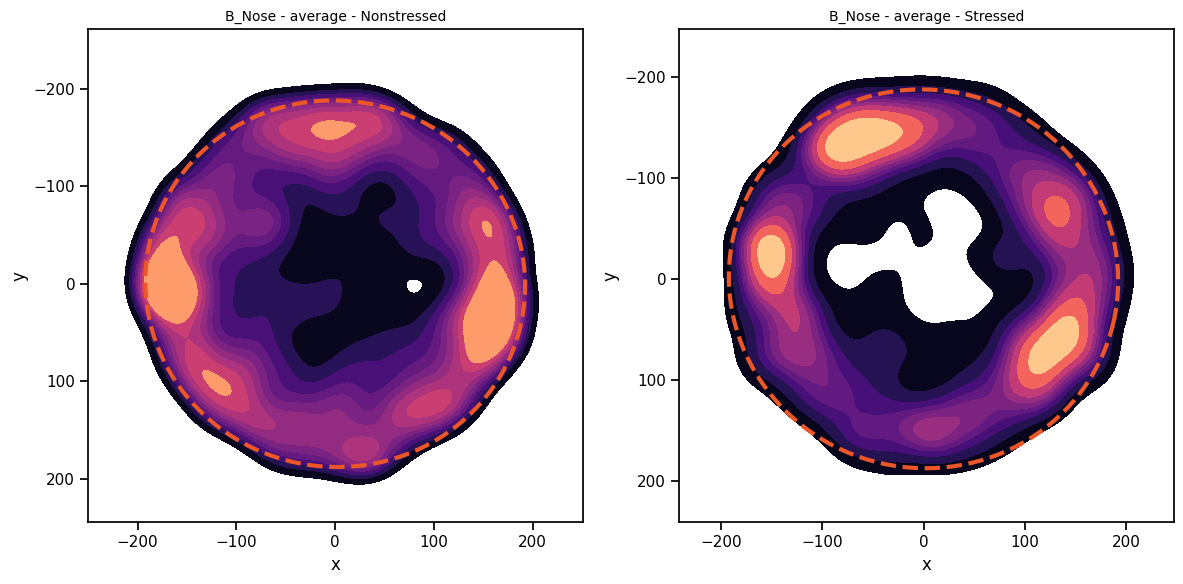

In [23]:
sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project,
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

It seems stressed animals spend more time closer to the walls of the arena, and less time in the center! For details on how deepof.visuals.plot_heatmap() works, feel free to check the full API reference or the function docstring.

We can also have a more detailed look at our data. As in most deepof plot functions, we can limit the time range that we want to include in our plot. For this the optional input arguments bin_index and bin_size can be used. They allow to either specify a bin size in seconds that is used to bin all data and then select one of the resulting bins via bin_index, or to directly specify the start time and duration of the segment you want to plot. Below you see the syntax for plotting the third minute 0:2:0-0:3:0 (or the third 60 seconds bin i.e. bin no. 2 as bin numbering starts at 0) for our data:

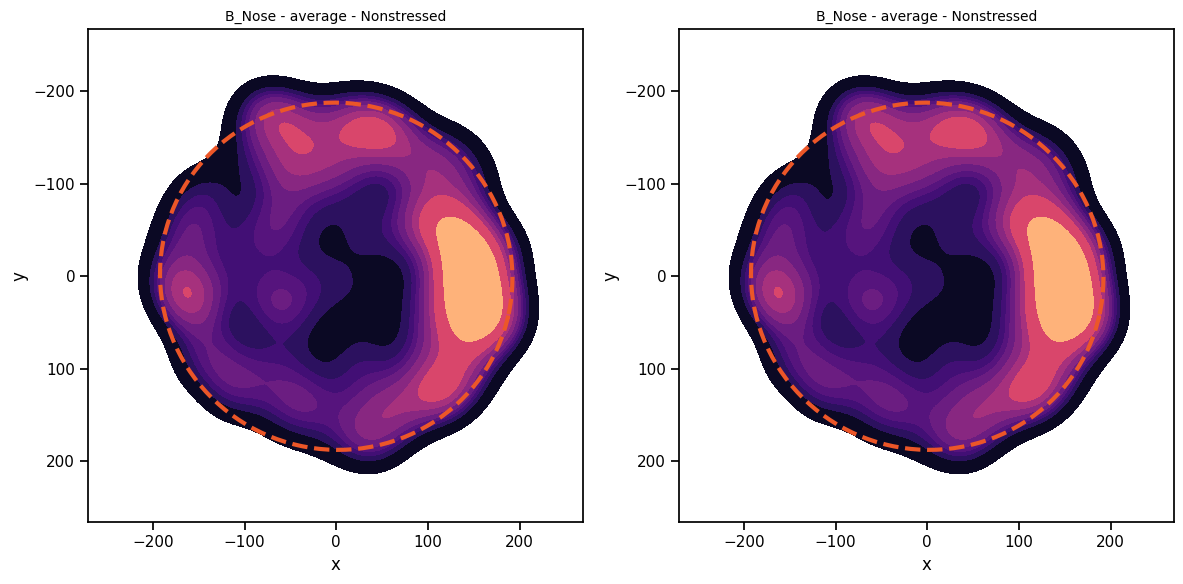

In [24]:
sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
    bin_index=2,  #plots only the second 60 seconds of teh data
    bin_size=60
)

deepof.visuals.plot_heatmaps(
    my_deepof_project,
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed", 
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
    bin_index="00:02:00",  #does the same as the above
    bin_size="00:01:00",
)

plt.tight_layout()
plt.show()

If you want very specific samples to get plotted, you also can use the precomputed_bins options and enter a boolean array. Here we do the same plot as above but by directly stating which samples should be included. The remaining samples not specified in the list get filled up with "False".

<Figure size 600x600 with 0 Axes>

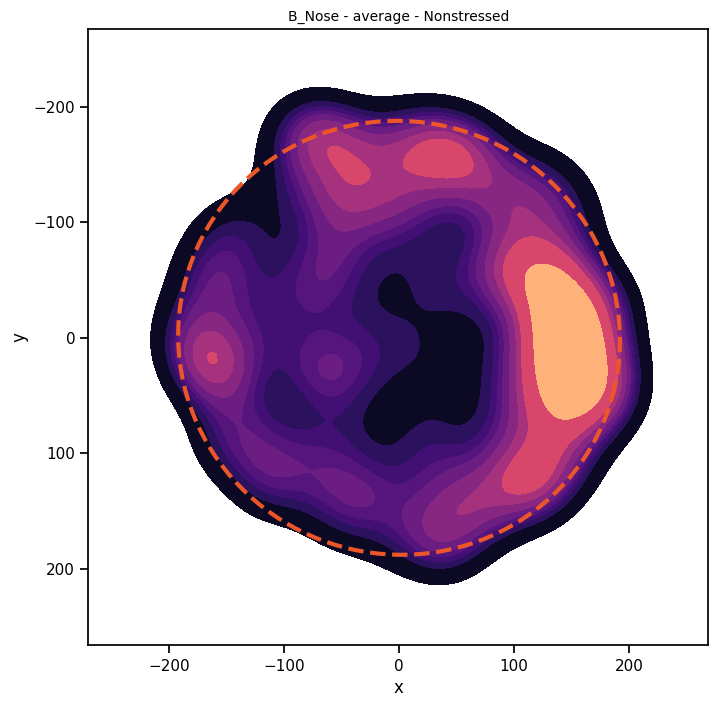

In [25]:
plt.figure(figsize=(6, 6))


deepof.visuals.plot_heatmaps(
    my_deepof_project,
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed", 
    show=False,
    display_arena=True,
    experiment_id="average",
    precomputed_bins=[False]*2998+[True]*1498,
)

plt.show()

### Regions of interest

Next to time-binning, deepof now also offers using different regions of interest (ROIs) that get drawn during project creation. You can define a new project and draw ROIs yourself by simply uncommenting the "# number_of_rois=3" in the prject definition block at the beginning of this tutorial. However, for your conveniece wa also prepared a short example project that already contains ROIs. You can load it via:

In [26]:
# Load a previously saved project
my_deepof_project_with_rois = deepof.data.load_project("./tutorial_files/sample_project/")
# And load the experiment conditions
my_deepof_project_with_rois.load_exp_conditions("./tutorial_files/tutorial_exp_conditions.csv")

The three that defined for this project cover roughly the top hald, the bottom half and the center of the arena. The only difference between our previous project and this one is the presence of ROIs. If we just plot it as before, we will get the exact same results.

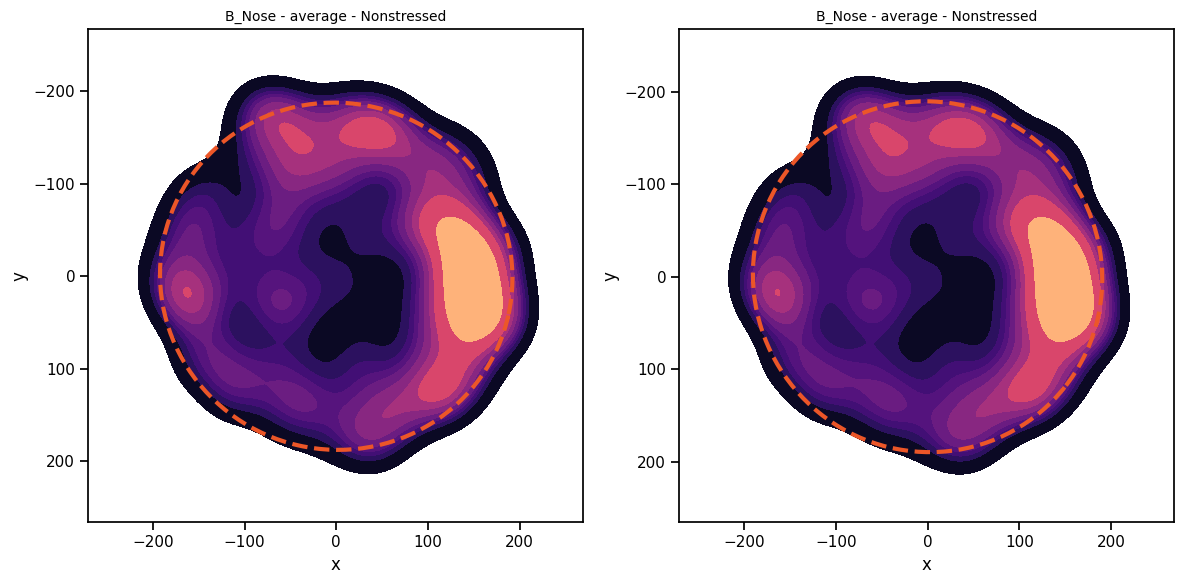

In [27]:
sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
    bin_index=2,  
    bin_size=60
)

deepof.visuals.plot_heatmaps(
    my_deepof_project_with_rois,
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed", 
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
    bin_index=2,  
    bin_size=60
)

plt.tight_layout()
plt.show()

Respectively, to make use of our ROIs we need to explicitely apply them. In most plot functions this can simply be done by setting the "roi_number" and the "animal_id" input argument. The input "roi_number" which roi should be used and "animal_id" (if there are multiple animals) determines to which animal the ROI should be applied. This will result in only the data getting included into the plot in which the respective animal was inside the selected ROI.

The following kwargs were not used by contour: 'animal_id'
The following kwargs were not used by contour: 'animal_id'


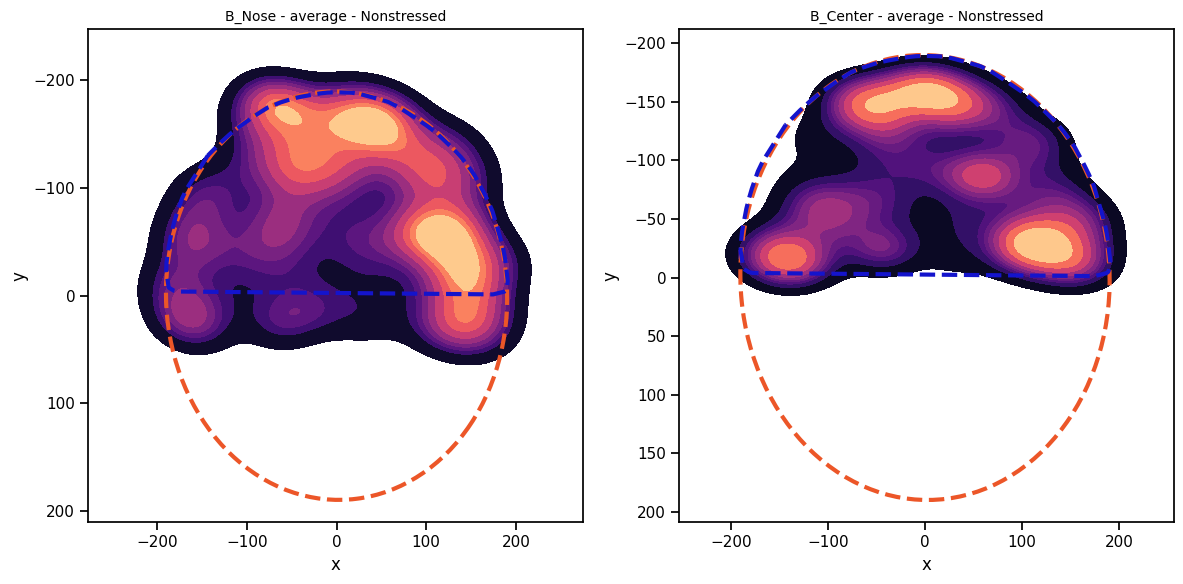

In [28]:
# we now only plot 

sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Nose based plot
deepof.visuals.plot_heatmaps(
    my_deepof_project_with_rois, 
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
    bin_index=2,  
    bin_size=60,
    roi_number=1,
    animal_id="B",
)

# Center based plot
deepof.visuals.plot_heatmaps(
    my_deepof_project_with_rois,
    ["B_Center"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed", 
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
    bin_index=2,  
    bin_size=60,
    roi_number=1,
    animal_id="B",
)

plt.tight_layout()
plt.show()

Note that the position of the "Center" of the mouse deterimines if it is inside or outside of a ROI. As the left plot above tracks the position of the Nose, large sections of the heatmap stretch outside of the annotated ROI.

If you want to extract coordinates while applying ROIs, you can just set the "roi_number" input option when using the get_coords function. This will result in rows getting set to NaN if the animal to which the data belongs was not inside of the ROI at the given time point. Everything else works as before.

In [29]:
coords = my_deepof_project_with_rois.get_coords(roi_number=1)
coords.filter_id("B")['20191204_Day2_SI_JB08_Test_54']

B_Center             B_Left_bhip              \
                             x           y           x           y   
00:00:00            178.695067  150.903525  178.133481  164.579831   
00:00:00.040002666  178.695067  150.903525  178.133481  164.579831   
00:00:00.080005333  178.695067  150.903525  178.133481  164.579831   
00:00:00.120008     177.009679  149.650528  175.106624  163.666017   
00:00:00.160010667  177.767518  147.833830  173.779126  162.437004   
...                        ...         ...         ...         ...   
00:09:59.799986665         NaN         NaN         NaN         NaN   
00:09:59.839989332         NaN         NaN         NaN         NaN   
00:09:59.879991999         NaN         NaN         NaN         NaN   
00:09:59.919994666         NaN         NaN         NaN         NaN   
00:09:59.959997333         NaN         NaN         NaN         NaN   

                    B_Left_ear             B_Left_fhip              \
                             x           y           x           y   
00:00:00            160.236194  129.369839  162.932410  149.543005   
00:00:00.040002666  160.236194  129.369839  162.932410  149.543005   
00:00:00.080005333  160.236194  129.369839  162.932410  149.543005   
00:00:00.120008     163.807836  124.262824  161.761900  147.278549   
00:00:00.160010667  167.520924  121.969513  163.445137  144.056996   
...                        ...         ...         ...         ...   
00:09:59.799986665         NaN         NaN         NaN         NaN   
00:09:59.839989332         NaN         NaN         NaN         NaN   
00:09:59.879991999         NaN         NaN         NaN         NaN   
00:09:59.919994666         NaN         NaN         NaN         NaN   
00:09:59.959997333         NaN         NaN         NaN         NaN   

                        B_Nose              ... B_Right_ear              \
                             x           y  ...           x           y   
00:00:00            166.288734  115.459213  ...  175.473650  127.391220   
00:00:00.040002666  166.288734  115.459213  ...  175.473650  127.391220   
00:00:00.080005333  166.288734  115.459213  ...  175.473650  127.391220   
00:00:00.120008     174.192032  112.040097  ...  180.079795  125.958622   
00:00:00.160010667  179.274246  108.299092  ...  183.599288  123.947488   
...                        ...         ...  ...         ...         ...   
00:09:59.799986665         NaN         NaN  ...         NaN         NaN   
00:09:59.839989332         NaN         NaN  ...         NaN         NaN   
00:09:59.879991999         NaN         NaN  ...         NaN         NaN   
00:09:59.919994666         NaN         NaN  ...         NaN         NaN   
00:09:59.959997333         NaN         NaN  ...         NaN         NaN   

                   B_Right_fhip               B_Spine_1              \
                              x           y           x           y   
00:00:00             181.920601  137.218331  170.050867  140.762637   
00:00:00.040002666   181.920601  137.218331  170.050867  140.762637   
00:00:00.080005333   181.920601  137.218331  170.050867  140.762637   
00:00:00.120008      184.009635  136.824217  171.210362  138.769813   
00:00:00.160010667   186.337662  135.377970  173.565589  136.397291   
...                         ...         ...         ...         ...   
00:09:59.799986665          NaN         NaN         NaN         NaN   
00:09:59.839989332          NaN         NaN         NaN         NaN   
00:09:59.879991999          NaN         NaN         NaN         NaN   
00:09:59.919994666          NaN         NaN         NaN         NaN   
00:09:59.959997333          NaN         NaN         NaN         NaN   

                     B_Spine_2             B_Tail_base              
                             x           y           x           y  
00:00:00            190.880247  157.459358  204.986693  161.780679  
00:00:00.040002666  190.880247  157.459358  204.986693  161.780679  
00:00:00.080005333  190.

In [30]:
my_deepof_project_with_rois.get_coords(roi_number=2).merge(my_deepof_project_with_rois.get_distances(roi_number=2))['20191204_Day2_SI_JB08_Test_54']

B_Center             B_Left_bhip             B_Left_ear  \
                            x           y           x           y          x   
00:00:00                  NaN         NaN         NaN         NaN        NaN   
00:00:00.040002666        NaN         NaN         NaN         NaN        NaN   
00:00:00.080005333        NaN         NaN         NaN         NaN        NaN   
00:00:00.120008           NaN         NaN         NaN         NaN        NaN   
00:00:00.160010667        NaN         NaN         NaN         NaN        NaN   
...                       ...         ...         ...         ...        ...   
00:09:59.799986665  87.802400  245.478268  103.222547  240.694477  86.352889   
00:09:59.839989332  87.996004  251.604048  103.329278  244.701390  84.727063   
00:09:59.879991999  88.189609  257.729827  101.048435  252.178232  83.101238   
00:09:59.919994666  88.189609  257.729827  101.048435  252.178232  83.101238   
00:09:59.959997333  88.189609  257.729827  101.048435  252.178232  83.101238   

                               B_Left_fhip                 B_Nose              \
                             y           x           y          x           y   
00:00:00                   NaN         NaN         NaN        NaN         NaN   
00:00:00.040002666         NaN         NaN         NaN        NaN         NaN   
00:00:00.080005333         NaN         NaN         NaN        NaN         NaN   
00:00:00.120008            NaN         NaN         NaN        NaN         NaN   
00:00:00.160010667         NaN         NaN         NaN        NaN         NaN   
...                        ...         ...         ...        ...         ...   
00:09:59.799986665  275.400892   96.059205  258.098621  74.008872  292.358501   
00:09:59.839989332  283.767822   97.459238  262.037313  75.703366  297.466060   
00:09:59.879991999  292.134752   96.435058  270.932931  70.169246  305.492866   
00:09:59.919994666  292.134752   96.435058  270.932931  70.169246  305.492866   
00:09:59.959997333  292.134752   96.435058  270.932931  70.169246  305.492866   

                    ... B_Left_ear   B_Center   B_Spine_2 B_Tail_base  \
                    ...  B_Spine_1  B_Spine_2 B_Tail_base      W_Nose   
00:00:00            ...        NaN        NaN         NaN         NaN   
00:00:00.040002666  ...        NaN        NaN         NaN         NaN   
00:00:00.080005333  ...        NaN        NaN         NaN         NaN   
00:00:00.120008     ...        NaN        NaN         NaN         NaN   
00:00:00.160010667  ...        NaN        NaN         NaN         NaN   
...                 ...        ...        ...         ...         ...   
00:09:59.799986665  ...  16.963757  16.876615   14.714033  172.650733   
00:09:59.839989332  ...  20.442886  19.611011   14.576627  169.636565   
00:09:59.879991999  ...  19.483884  17.657623   15.374271  168.414230   
00:09:59.919994666  ...  19.483884  17.657623   15.374271  168.414230   
00:09:59.959997333  ...  19.483884  17.657623   15.374271  168.414230   

                       B_Center W_Right_bhip B_Tail_base   W_Spine_2  \
                   B_Right_fhip    W_Spine_2 W_Tail_base W_Tail_base   
00:00:00                    NaN          NaN         NaN         NaN   
00:00:00.040002666          NaN          NaN         NaN         NaN   
00:00:00.080005333          NaN          NaN         NaN         NaN   
00:00:00.120008             NaN          NaN         NaN         NaN   
00:00:00.160010667          NaN          NaN         NaN         NaN   
...                         ...          ...         ...         ...   
00:09:59.799986665    12.375443    13.610203  231.732647   13.522631   
00:09:59.839989332    10.576273    13.740181  228.571928   13.512709   
00:09:59.879991999    12.405546    13.761130  226.395893   13.529974   
00:09:59.919994666    12.405546    13.761130  226.395893   13.529974   
00:09:59.959997333    12.405546    13.761130  226.395893   13.529974   

                   W_Right_ear   W_Cent

One detail worth mentioning is that for distances between two different animals, both animals must have been inside the ROI if a ROI is selected

Finally, let's create an animated video showing our newly preprocessed data. DeepOF can produce reconstructions of the tracks and show them as videos. All animals and the arena are displayed by default. This is particularly useful when interpreting clusters and visualizing embeddings in the unsupervised pipeline, as we'll see in a later turorial.

In [31]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project_with_rois,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    bin_index=0,
    bin_size=20,
    sampling_rate=15,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

Analogously to plot_heatmaps, you can also apply ROIs to animate_skeleton. This will result in all frames getting excluded in which a given animal is not inside of the ROI

In [32]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project_with_rois,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    bin_index=0,
    bin_size=20,
    sampling_rate=15,
    dpi=60,
    roi_number=1,
    animal_id="W",
)

html = display.HTML(video)
display.display(html)
plt.close()

### What's next

That's it for this tutorial. [Next](https://deepof.readthedocs.io/en/latest/tutorial_notebooks/deepof_supervised_tutorial.html), we'll see how to run a supervised annotation pipeline with pretrained models!